## Import

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
import random
import pandas as pd
import numpy as np
import os
import glob
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import torchvision
import torchvision.models as models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import cv2
from tqdm.auto import tqdm

In [3]:
import os
os.environ["WANDB_DISABLED"] = "true"

import pandas as pd
import numpy as np
import cv2
import shutil
import yaml

from ultralytics import YOLO
from glob import glob
from tqdm import tqdm
from IPython.display import clear_output
from sklearn.model_selection import train_test_split

In [4]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

### 2D_JSON 파일 압축 풀기

In [5]:
import zipfile

def extract_images_from_zip(zip_path, folder_name):
    with zipfile.ZipFile(zip_path, 'r') as zip_file:
        file_list = zip_file.namelist()
        for file_name in tqdm(file_list):
            if folder_name in file_name:
                zip_file.extract(file_name, path='./')
                # print(f"Extracted {file_name}")

In [6]:
# 라벨링 데이터 가져오기(Json 파일)
zip_path_list = ['./01.데이터/2.Validation/원천데이터/VS1.온전.zip',
                 ]

for zip_path in zip_path_list:
    extract_images_from_zip(zip_path, 'IMAGE')

100%|██████████| 39880/39880 [04:55<00:00, 135.04it/s]   


In [7]:
# 라벨링 데이터 가져오기(Json 파일)
zip_path_list = ['./01.데이터/2.Validation/라벨링데이터/VL1.온전.zip',
                 ]

for zip_path in zip_path_list:
    extract_images_from_zip(zip_path, '2D_JSON')

100%|██████████| 13293/13293 [00:15<00:00, 838.55it/s]


100%|██████████| 13292/13292 [01:37<00:00, 136.99it/s]


카테고리 ID 별 빈도:
{384: 1184, 385: 24203, 386: 1972, 387: 8241, 388: 179, 389: 13, 390: 309, 391: 211, 392: 91, 394: 13, 395: 4, 396: 30, 399: 1, 400: 12, 401: 1151, 402: 3, 404: 8, 407: 1, 408: 1, 410: 61, 411: 72, 412: 52, 415: 9213, 416: 238, 417: 12, 418: 10633, 419: 5077, 421: 821, 424: 221, 425: 2, 428: 3337, 429: 2, 430: 278, 431: 7, 432: 70, 433: 41, 440: 7369, 381: 1449, 382: 23, 383: 22803}


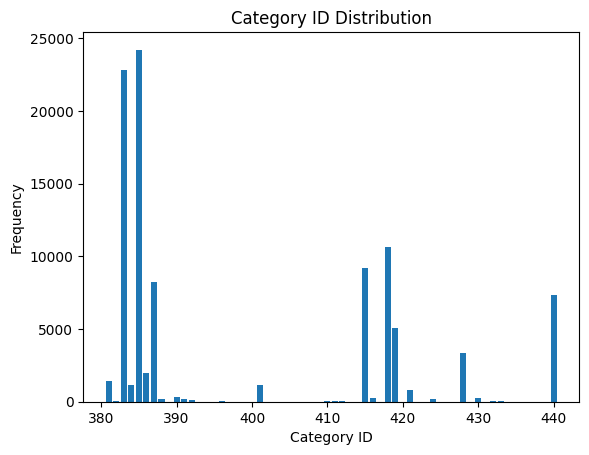

In [7]:
import os
import json
import matplotlib.pyplot as plt
from tqdm import tqdm

def get_category_ids(json_file_path):
    with open(json_file_path, 'r', encoding='utf-8') as json_file:
        data = json.load(json_file)
        annotations = data.get('annotations', [])
        category_ids = [annotation['category_id'] for annotation in annotations]
    return category_ids

def get_all_category_ids_in_directory(directory_path):
    all_category_ids = []
    json_files = [file for file in os.listdir(directory_path) if file.endswith('.json')]

    for json_file in tqdm(json_files):
        file_path = os.path.join(directory_path, json_file)
        category_ids = get_category_ids(file_path)
        all_category_ids.extend(category_ids)

    return all_category_ids

# 경로 설정
json_directory_path = './2D_JSON/'

# 모든 JSON 파일에서 카테고리 ID의 종류 확인
all_category_ids = get_all_category_ids_in_directory(json_directory_path)

# 카테고리 ID 별 빈도 계산
category_counts = {category_id: all_category_ids.count(category_id) for category_id in set(all_category_ids)}

# 결과 출력 및 시각화
print("카테고리 ID 별 빈도:")
print(category_counts)

# 시각화
plt.bar(category_counts.keys(), category_counts.values())
plt.xlabel('Category ID')
plt.ylabel('Frequency')
plt.title('Category ID Distribution')
plt.show()

In [8]:
# 결과 출력 및 시각화
print("카테고리 ID 별 빈도:")
print(category_counts)

# 1000개 이상의 분포를 가진 카테고리 ID 확인
over_ids = [category_id for category_id, count in category_counts.items() if count >= 1000]
print("N개 이상 분포하는 카테고리 ID:")
print(over_ids)

카테고리 ID 별 빈도:
{384: 1184, 385: 24203, 386: 1972, 387: 8241, 388: 179, 389: 13, 390: 309, 391: 211, 392: 91, 394: 13, 395: 4, 396: 30, 399: 1, 400: 12, 401: 1151, 402: 3, 404: 8, 407: 1, 408: 1, 410: 61, 411: 72, 412: 52, 415: 9213, 416: 238, 417: 12, 418: 10633, 419: 5077, 421: 821, 424: 221, 425: 2, 428: 3337, 429: 2, 430: 278, 431: 7, 432: 70, 433: 41, 440: 7369, 381: 1449, 382: 23, 383: 22803}
N개 이상 분포하는 카테고리 ID:
[384, 385, 386, 387, 401, 415, 418, 419, 428, 440, 381, 383]


### Annotation: B-box

In [9]:
def normalize_bbox(bbox, image_width, image_height):
    x_min = bbox[0]
    y_min = bbox[1]
    width = bbox[2]
    height = bbox[3]

    x_center = (x_min + width / 2) / image_width
    y_center = (y_min + height / 2) / image_height
    norm_width = width / image_width
    norm_height = height / image_height

    return x_center, y_center, norm_width, norm_height

In [20]:
# 이미지 파일 위치한 폴더들과 어노테이션 파일이 위치한 폴더들의 경로
image_folders = ['./IMAGE/']

annotation_folders = ['./2D_JSON/']

# 대상 폴더가 존재하지 않으면 생성
if not os.path.exists('./Labels/'):
    os.makedirs('./Labels/')

In [21]:
def has_bbox_only(annotation):
    return 'bbox' in annotation and 'category_id' in annotation and all(key not in annotation for key in ['segmentation', 'polyline'])

In [15]:
category_ids = []

for image_folder, annotation_folder in zip(image_folders, annotation_folders):
    # 이미지 폴더 내의 파일 목록을 가져옴
    image_files = os.listdir(image_folder)

    # 이미지 파일과 어노테이션 파일을 한 쌍씩 처리
    for image_file in image_files:
        # 이미지 파일의 경로
        image_path = os.path.join(image_folder, image_file)

        # 어노테이션 파일의 경로
        annotation_file = os.path.splitext(image_file)[0] + '.json'
        annotation_path = os.path.join(annotation_folder, annotation_file)

        # 어노테이션 파일을 열어 bbox 정보를 추출하여 텍스트 파일로 저장
        with open(annotation_path, 'r') as f:
            annotation_data = json.load(f)

            # 이미지 정보와 어노테이션 정보에서 필요한 값 추출
            image_info = annotation_data['images'][0]
            annotations = annotation_data['annotations']

            # 이미지 정보에서 파일명 추출
            image_filename = image_info['filename']
            image_width = image_info['width']
            image_height = image_info['height']

            # bbox 값이 있는 어노테이션만 처리하여 텍스트 파일로 저장 (bbox 값 가지지 않는 이미지 존재하기 때문)
            annotated_annotations = [annotation for annotation in annotations if has_bbox_only(annotation)]

            if len(annotated_annotations) > 0:
                # 텍스트 파일 경로
                for annotation in annotated_annotations:
                    
                    bbox = annotation['bbox']
                    category_id = annotation['category_id']
                    
                    category_ids.append(category_id)

In [16]:
from collections import Counter
cid = Counter(category_ids)
cid

Counter({419: 2534,
         418: 5313,
         401: 1151,
         424: 220,
         430: 277,
         415: 3,
         429: 1,
         410: 61,
         387: 1,
         402: 3,
         417: 1,
         381: 1,
         386: 1,
         385: 2,
         425: 2})

In [18]:
filtered_categories = [category for category, count in cid.items() if count >= 10]

# 결과 출력
print(filtered_categories)

[419, 418, 401, 424, 430, 410]


In [22]:
import os
import json

# (각각의 폴더에서) 이미지와 각 이미지에 대한 2D 어노테이션 파일
# YOLOv8 detection 모델에 적용할 수 있는 형태로 저장

# 이미지 폴더와 어노테이션 폴더를 반복하여 처리
for image_folder, annotation_folder in zip(image_folders, annotation_folders):
    # 이미지 폴더 내의 파일 목록을 가져옴
    image_files = os.listdir(image_folder)

    # 이미지 파일과 어노테이션 파일을 한 쌍씩 처리
    for image_file in tqdm(image_files):
        # 이미지 파일의 경로
        image_path = os.path.join(image_folder, image_file)

        # 어노테이션 파일의 경로
        annotation_file = os.path.splitext(image_file)[0] + '.json'
        annotation_path = os.path.join(annotation_folder, annotation_file)

        # 어노테이션 파일을 열어 bbox 정보를 추출하여 텍스트 파일로 저장
        with open(annotation_path, 'r') as f:
            annotation_data = json.load(f)

            # 이미지 정보와 어노테이션 정보에서 필요한 값 추출
            image_info = annotation_data['images'][0]
            annotations = annotation_data['annotations']

            # 이미지 정보에서 파일명 추출
            image_filename = image_info['filename']
            image_width = image_info['width']
            image_height = image_info['height']

            # bbox 값이 있는 어노테이션만 처리하여 텍스트 파일로 저장 (bbox 값 가지지 않는 이미지 존재하기 때문)
            annotated_annotations = [annotation for annotation in annotations if has_bbox_only(annotation)]

            if len(annotated_annotations) > 0:
                # 텍스트 파일 경로
                txt_file = os.path.splitext(image_file)[0] + '.txt'
                txt_path = os.path.join('./Labels/', txt_file) # annotation(bbox) .txt 저장 경로

                with open(txt_path, 'w') as txt_f:
                    for annotation in annotated_annotations:
                        
                        bbox = annotation['bbox']
                        category_id = annotation['category_id']

                        if category_id in filtered_categories:
                            x_center, y_center, norm_width, norm_height = normalize_bbox(bbox, image_width, image_height)

                            if category_id == 401: # 속도제한
                                class_index = 0
                            elif category_id == 410: #서행(횡단보도 예고)
                                class_index = 1
                            elif category_id == 418: #진행방면1
                                class_index = 2
                            elif category_id == 419: #진행방면2
                                class_index = 3
                            elif category_id == 424: #서행 
                                class_index = 1
                            elif category_id == 430: #서행(양보)
                                class_index = 1
                        line = f'{class_index} {x_center} {y_center} {norm_width} {norm_height}\n'
                        txt_f.write(line)
            else:
                # bbox 값이 없는 어노테이션 -> 건너뛰고 처리하지 않음
                continue

100%|██████████| 13292/13292 [00:10<00:00, 1257.77it/s]


In [23]:
import os

directory = './Labels/'
class_id_to_check = 0

# 해당 경로의 모든 파일을 가져옵니다.
files = os.listdir(directory)

# class ID가 조회된 파일을 저장할 리스트를 초기화합니다.
class_1_files = []

# 각 파일에 대해 처리합니다.
for file in tqdm(files):
    # 파일이 텍스트 파일인지 확인합니다.
    if file.endswith('.txt'):
        file_path = os.path.join(directory, file)

        # 파일을 열어서 내용을 읽습니다.
        with open(file_path, 'r') as f:
            # 파일 내용을 줄 단위로 읽습니다.
            lines = f.readlines()

            # 첫 번째 줄에서 class ID를 확인합니다.
            if lines:
                first_line = lines[0].strip().split()
                if len(first_line) > 0 and int(first_line[0]) == class_id_to_check:
                    class_1_files.append(file)

# class ID가 조회된 파일 목록을 출력합니다.
print(f"Class ID {class_id_to_check}를 포함하는 파일 목록:")
for file in class_1_files:
    print(file)

  0%|          | 0/5881 [00:00<?, ?it/s]

100%|██████████| 5881/5881 [00:33<00:00, 177.37it/s]

Class ID 0를 포함하는 파일 목록:
0101_light_clear_smooth_01000070.txt
0101_light_clear_smooth_01000071.txt
0101_light_clear_smooth_01000072.txt
0101_light_clear_smooth_01000073.txt
0101_light_clear_smooth_01000117.txt
0101_light_clear_smooth_01000118.txt
0101_light_clear_smooth_01000119.txt
0101_light_clear_smooth_01000120.txt
0101_light_clear_smooth_01000284.txt
0101_light_clear_smooth_01000285.txt
0101_light_clear_smooth_01000304.txt
0101_light_clear_smooth_01000309.txt
0101_light_clear_smooth_01000338.txt
0101_light_clear_smooth_01000437.txt
0101_light_clear_smooth_01000438.txt
0101_light_clear_smooth_02000010.txt
0101_light_clear_smooth_02000011.txt
0101_light_clear_smooth_02000045.txt
0101_light_clear_smooth_02000185.txt
0101_light_clear_smooth_03000000.txt
0101_light_clear_smooth_03000001.txt
0101_light_clear_smooth_03000044.txt
0101_light_clear_smooth_03000045.txt
0101_light_clear_smooth_03000066.txt
0101_light_clear_smooth_03000067.txt
0101_light_clear_smooth_03000068.txt
0101_light_cle

In [24]:
import os

image_path = "./IMAGE/"
label_path = "./Labels/"

# 이미지 디렉토리에서 파일 목록을 가져옴
image_files = os.listdir(image_path)

for image_file in image_files:
    # 이미지 파일 이름에서 확장자를 제거하여 라벨 파일 이름 생성
    label_file = os.path.splitext(image_file)[0] + ".txt"
    
    # 라벨 파일의 전체 경로 확인
    label_file_path = os.path.join(label_path, label_file)
    
    # 라벨 파일이 존재하지 않으면 해당 이미지 파일 삭제
    if not os.path.exists(label_file_path):
        image_file_path = os.path.join(image_path, image_file)
        os.remove(image_file_path)
        print(f"Deleted {image_file}")

print("Processing complete.")


Deleted 0101_light_clear_smooth_01000002.png
Deleted 0101_light_clear_smooth_01000003.png
Deleted 0101_light_clear_smooth_01000004.png
Deleted 0101_light_clear_smooth_01000005.png
Deleted 0101_light_clear_smooth_01000006.png
Deleted 0101_light_clear_smooth_01000008.png
Deleted 0101_light_clear_smooth_01000020.png
Deleted 0101_light_clear_smooth_01000022.png
Deleted 0101_light_clear_smooth_01000024.png
Deleted 0101_light_clear_smooth_01000025.png
Deleted 0101_light_clear_smooth_01000030.png
Deleted 0101_light_clear_smooth_01000031.png
Deleted 0101_light_clear_smooth_01000032.png
Deleted 0101_light_clear_smooth_01000033.png
Deleted 0101_light_clear_smooth_01000034.png
Deleted 0101_light_clear_smooth_01000036.png
Deleted 0101_light_clear_smooth_01000037.png
Deleted 0101_light_clear_smooth_01000039.png
Deleted 0101_light_clear_smooth_01000041.png
Deleted 0101_light_clear_smooth_01000043.png
Deleted 0101_light_clear_smooth_01000045.png
Deleted 0101_light_clear_smooth_01000046.png
Deleted 01

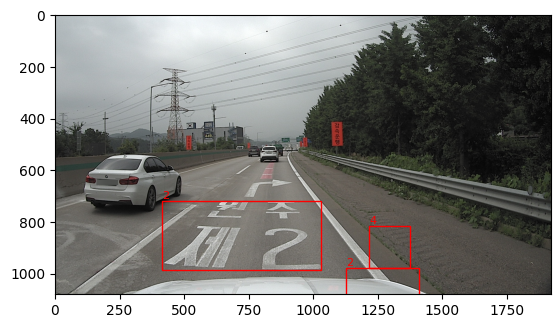

In [39]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 이미지 파일 경로
image_path = "./IMAGE/0101_light_clear_smooth_01000000.png"

# 텍스트 파일 경로
txt_path = "./Labels/0101_light_clear_smooth_01000000.txt"

# 이미지 불러오기
image = cv2.imread(image_path)

# 텍스트 파일 읽기
with open(txt_path, 'r') as file:
    lines = file.readlines()

# 이미지 시각화
fig, ax = plt.subplots(1)
ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# 좌표값 시각화
for line in lines:
    values = line.split()
    label = values[0]
    x, y, width, height = map(float, values[1:])
    
    # 좌표값을 이용한 사각형 생성
    rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
    
    # 사각형을 그래프에 추가
    ax.add_patch(rect)
    
    # 텍스트 추가 (optional)
    ax.text(x, y, label, color='r', fontsize=8, verticalalignment='bottom')

# 결과 보여주기
plt.show()


### train

In [25]:
import os
import random
import shutil

# 원본 이미지와 라벨이 있는 디렉토리 경로
image_dir = "./IMAGE/"
label_dir = "./Labels/"

# 새로 생성할 디렉토리 경로
output_dir = ["./train/", "./validation/"]

# 이미지 및 라벨 하위 폴더 생성
for directory in output_dir:
    os.makedirs(os.path.join(directory, "images"), exist_ok=True)
    os.makedirs(os.path.join(directory, "labels"), exist_ok=True)

# 이미지 및 라벨 파일 목록 가져오기
image_files = os.listdir(image_dir)
label_files = os.listdir(label_dir)

# 이미지 및 라벨 파일을 랜덤하게 섞음
random.shuffle(image_files)

# 데이터 분할 비율 설정 (8:1:1)
train_ratio = 0.8
validation_ratio = 0.2

# 데이터 분할 및 이동
total_samples = len(image_files)
train_samples = int(total_samples * train_ratio)
validation_samples = int(total_samples * validation_ratio)

train_images = image_files[:train_samples]
validation_images = image_files[train_samples:train_samples + validation_samples]

def move_files(src_dir, dest_dir, files):
    for file in tqdm(files):
        shutil.copy(os.path.join(image_dir, file), os.path.join(dest_dir, "images"))
        shutil.copy(os.path.join(label_dir, file.replace(".png", ".txt")), os.path.join(dest_dir, "labels"))

# 훈련 데이터 이동
move_files(image_dir, output_dir[0], train_images)

# 검증 데이터 이동
move_files(image_dir, output_dir[1], validation_images)


  0%|          | 0/4704 [00:00<?, ?it/s]

100%|██████████| 1176/1176 [00:22<00:00, 52.48it/s]


In [26]:
import os
import matplotlib.pyplot as plt
import numpy as np

def read_bbox_info(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    return [line.strip().split() for line in lines]

def visualize_class_distribution(data_folder):
    class_counts = {}

    # Iterate through each text file in the folder
    for file_name in os.listdir(data_folder):
        if file_name.endswith(".txt"):
            file_path = os.path.join(data_folder, file_name)

            # Read bbox information from the file
            bbox_info_list = read_bbox_info(file_path)

            # Extract class information from bbox info and count occurrences
            for bbox_info in bbox_info_list:
                class_label = int(bbox_info[0])
                class_counts[class_label] = class_counts.get(class_label, 0) + 1

    # Plot the class distribution
    labels, counts = zip(*class_counts.items())
    class_labels = [str(label) for label in labels]

    fig, ax = plt.subplots()
    ax.bar(class_labels, counts, align='center')
    ax.set_xlabel('Class Label')
    ax.set_ylabel('Count')
    ax.set_title('Class Distribution of Bounding Boxes')
    plt.show()

# YOLOv8 모델 학습(B-box 인식 모델)

In [30]:
if not os.path.exists("./Model/"):
    os.makedirs("./Model/")

In [90]:
import ultralytics
from ultralytics import YOLO

ultralytics.checks()

Ultralytics YOLOv8.1.2 🚀 Python-3.8.17 torch-2.0.0 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11264MiB)
Setup complete ✅ (8 CPUs, 63.7 GB RAM, 424.3/953.2 GB disk)


In [80]:
BATCH_SIZE = 16
Image_Size = 640
epochs = 100
patience = 5
workers = 8
device = 0 # torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
SEED = 42
lr0 = 1e-4

# Model Value
model_name = 'yolov8m'
MODEL = f"./Model/v_{model_name}_{Image_Size}"

In [91]:
# 최적화된 하이퍼파라미터를 사용하여 YOLO 모델을 학습 및 결과 확인
model = YOLO(f"{model_name}.pt")

results = model.train(
    data="./data.yaml",
    imgsz=(Image_Size, Image_Size),
    epochs=epochs,
    batch=BATCH_SIZE,
    patience=patience,
    workers=workers,
    device=device,
    exist_ok=True,
    project=f"{MODEL}",
    name="train",
    seed=SEED,
    pretrained=True,
    resume=False,
    optimizer="Adam",
    lr0=lr0,
    augment=False,
    val=True,
    cache=True,
)

Ultralytics YOLOv8.1.2 🚀 Python-3.8.17 torch-2.0.0 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11264MiB)
engine\trainer: task=detect, mode=train, model=yolov8m.pt, data=./data.yaml, epochs=100, time=None, patience=5, batch=16, imgsz=(640, 640), save=True, save_period=-1, cache=True, device=0, workers=8, project=./Model/v_yolov8m_640, name=train, exist_ok=True, pretrained=True, optimizer=Adam, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_co

train: Scanning C:\roadmark_YOLOv8\train\labels... 4704 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4704/4704 [00:52<00:00, 88.87it/s] 


train: WARNING ⚠️ C:\roadmark_YOLOv8\train\images\0101_light_clear_smooth_03000481.png: 1 duplicate labels removed
train: WARNING ⚠️ C:\roadmark_YOLOv8\train\images\0101_light_clear_smooth_03000482.png: 1 duplicate labels removed
train: WARNING ⚠️ C:\roadmark_YOLOv8\train\images\0101_light_clear_smooth_03000970.png: 2 duplicate labels removed
train: WARNING ⚠️ C:\roadmark_YOLOv8\train\images\0101_light_clear_smooth_03001088.png: 1 duplicate labels removed
train: WARNING ⚠️ C:\roadmark_YOLOv8\train\images\0101_light_clear_smooth_03001507.png: 5 duplicate labels removed
train: WARNING ⚠️ C:\roadmark_YOLOv8\train\images\0101_light_clear_smooth_04000071.png: 2 duplicate labels removed
train: WARNING ⚠️ C:\roadmark_YOLOv8\train\images\0101_light_clear_smooth_04000259.png: 1 duplicate labels removed
train: WARNING ⚠️ C:\roadmark_YOLOv8\train\images\0101_light_clear_smooth_04000342.png: 1 duplicate labels removed
train: WARNING ⚠️ C:\roadmark_YOLOv8\train\images\0101_light_clear_smooth_040003

train: Caching images (3.0GB True): 100%|██████████| 4704/4704 [00:40<00:00, 116.93it/s]
val: Scanning C:\roadmark_YOLOv8\validation\labels... 1176 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1176/1176 [00:14<00:00, 79.14it/s]

val: WARNING ⚠️ C:\roadmark_YOLOv8\validation\images\0101_light_clear_smooth_03000969.png: 1 duplicate labels removed
val: WARNING ⚠️ C:\roadmark_YOLOv8\validation\images\0101_light_clear_smooth_03001506.png: 3 duplicate labels removed
val: WARNING ⚠️ C:\roadmark_YOLOv8\validation\images\0101_light_clear_smooth_04000343.png: 1 duplicate labels removed
val: WARNING ⚠️ C:\roadmark_YOLOv8\validation\images\0101_light_clear_smooth_04000346.png: 1 duplicate labels removed
val: WARNING ⚠️ C:\roadmark_YOLOv8\validation\images\0101_light_clear_smooth_04003881.png: 1 duplicate labels removed
val: WARNING ⚠️ C:\roadmark_YOLOv8\validation\images\0101_light_clear_smooth_04004360.png: 1 duplicate labels removed
val: WARNING ⚠️ C:\roadmark_YOLOv8\validation\images\0101_light_clear_smooth_04004361.png: 2 duplicate labels removed


val: New cache created: C:\roadmark_YOLOv8\validation\labels.cache


val: Caching images (0.8GB True): 100%|██████████| 1176/1176 [00:09<00:00, 119.83it/s]


Plotting labels to Model\v_yolov8m_640\train\labels.jpg... 
optimizer: Adam(lr=0.0001, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      8.69G      1.172      1.849      1.091         49        640: 100%|██████████| 294/294 [02:16<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:13<00:00,  2.69it/s]

                   all       1176       1904      0.805      0.382      0.422      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      9.32G     0.9748      1.153     0.9938         50        640: 100%|██████████| 294/294 [03:03<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:26<00:00,  1.40it/s]

                   all       1176       1904      0.483      0.576      0.549      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      9.28G     0.9252      1.012     0.9689         46        640: 100%|██████████| 294/294 [02:58<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:27<00:00,  1.33it/s]

                   all       1176       1904      0.738      0.514      0.606      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100       9.3G     0.8797      0.903     0.9549         53        640: 100%|██████████| 294/294 [03:36<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:26<00:00,  1.39it/s]

                   all       1176       1904      0.787      0.572       0.66       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      9.32G     0.8644     0.8653     0.9511         42        640: 100%|██████████| 294/294 [03:34<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:26<00:00,  1.39it/s]

                   all       1176       1904      0.725      0.627      0.686      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100       9.3G     0.8447     0.8223     0.9369         39        640: 100%|██████████| 294/294 [03:11<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:26<00:00,  1.40it/s]

                   all       1176       1904      0.743      0.635      0.695      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      9.33G     0.8351      0.793     0.9379         47        640: 100%|██████████| 294/294 [03:40<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:27<00:00,  1.34it/s]

                   all       1176       1904      0.716       0.68      0.731      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      9.34G      0.826     0.7784     0.9339         45        640: 100%|██████████| 294/294 [03:13<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:27<00:00,  1.35it/s]

                   all       1176       1904      0.768      0.679      0.728      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      9.35G     0.8137     0.7408     0.9287         73        640: 100%|██████████| 294/294 [03:41<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:27<00:00,  1.37it/s]

                   all       1176       1904      0.765      0.674      0.727      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      9.33G     0.8048     0.7148     0.9226         44        640: 100%|██████████| 294/294 [03:40<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:27<00:00,  1.34it/s]

                   all       1176       1904      0.711      0.716       0.74      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      9.31G     0.7961     0.7019     0.9201         56        640: 100%|██████████| 294/294 [03:42<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:27<00:00,  1.33it/s]

                   all       1176       1904      0.858      0.648       0.76      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      9.35G     0.7918     0.6848      0.921         46        640: 100%|██████████| 294/294 [03:40<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:27<00:00,  1.35it/s]

                   all       1176       1904      0.742      0.724      0.762      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      9.34G     0.7721     0.6797     0.9118         44        640: 100%|██████████| 294/294 [02:47<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:27<00:00,  1.36it/s]

                   all       1176       1904      0.818      0.725      0.781       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      9.31G     0.7683     0.6682     0.9073         47        640: 100%|██████████| 294/294 [03:11<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:27<00:00,  1.34it/s]

                   all       1176       1904      0.832      0.711      0.796      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      9.33G     0.7657      0.651     0.9148         47        640: 100%|██████████| 294/294 [03:40<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:27<00:00,  1.34it/s]

                   all       1176       1904      0.816      0.721       0.79      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      9.35G     0.7645     0.6389      0.909         48        640: 100%|██████████| 294/294 [03:57<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:26<00:00,  1.38it/s]

                   all       1176       1904      0.857       0.74      0.812      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      9.36G     0.7545     0.6227      0.909         53        640: 100%|██████████| 294/294 [03:58<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:27<00:00,  1.35it/s]

                   all       1176       1904      0.813      0.692      0.787        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      9.35G     0.7519     0.6104     0.9072         50        640: 100%|██████████| 294/294 [03:56<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:27<00:00,  1.36it/s]

                   all       1176       1904      0.819      0.736      0.799      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      9.31G     0.7474     0.6117     0.9078         56        640: 100%|██████████| 294/294 [03:40<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:28<00:00,  1.31it/s]

                   all       1176       1904      0.845      0.699      0.782      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      9.32G     0.7412     0.5827     0.9009         62        640: 100%|██████████| 294/294 [03:29<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:27<00:00,  1.35it/s]

                   all       1176       1904      0.869      0.693      0.794      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      9.34G      0.734     0.5915     0.9013         57        640: 100%|██████████| 294/294 [03:44<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:27<00:00,  1.34it/s]

                   all       1176       1904      0.811      0.713      0.794      0.598
Stopping training early as no improvement observed in last 5 epochs. Best results observed at epoch 16, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



21 epochs completed in 1.376 hours.
Optimizer stripped from Model\v_yolov8m_640\train\weights\last.pt, 52.0MB
Optimizer stripped from Model\v_yolov8m_640\train\weights\best.pt, 52.0MB

Validating Model\v_yolov8m_640\train\weights\best.pt...
Ultralytics YOLOv8.1.2 🚀 Python-3.8.17 torch-2.0.0 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11264MiB)
Model summary (fused): 218 layers, 25842655 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:15<00:00,  2.39it/s]


                   all       1176       1904      0.854      0.733      0.811      0.606
                     0       1176        226      0.868      0.854      0.905      0.701
                     1       1176       1069      0.898      0.842      0.917      0.721
                     2       1176        502      0.833      0.871      0.897      0.762
                     3       1176         52       0.78      0.479      0.578      0.346
                     4       1176         55      0.892      0.618      0.758      0.498
Speed: 0.2ms preprocess, 4.8ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to Model\v_yolov8m_640\train
